In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import torch
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from tslearn.metrics import dtw
from tslearn.metrics import cdist_dtw
from sklearn.metrics import silhouette_score
from tslearn.clustering import TimeSeriesKMeans

In [2]:
df = pd.read_excel("./process_data/dining area.xlsx")
df.head()

,start_time,end_time,temperature,luminosity,humidity
0,2022-05-01 00:00:00,2022-05-01 00:30:00,0.376901,0.087579,0.475664
1,2022-05-01 00:30:00,2022-05-01 01:00:00,0.460366,0.085515,0.492180
2,2022-05-01 01:00:00,2022-05-01 01:30:00,0.479522,0.085102,0.502993
3,2022-05-01 01:30:00,2022-05-01 02:00:00,0.464881,0.085515,0.509424
4,2022-05-01 02:00:00,2022-05-01 02:30:00,0.446955,0.085928,0.512793


In [3]:
datatypes = ["temperature", "luminosity", "humidity"]

In [4]:
morning_start = pd.to_datetime("04:30:00").time()
morning_end = pd.to_datetime("12:00:00").time()

afternoon_start = pd.to_datetime("12:00:00").time()
afternoon_end = pd.to_datetime("20:30:00").time()

In [5]:
dates = df["start_time"].dt.date.unique()

df_data = {
    "date": [],
    "time": [],
    "temperature": [],
    "luminosity": [],
    "humidity": []
}

In [6]:
for date in dates:
    rows = df[
        df["start_time"].dt.date == date
    ]

    """---------------MORNING TIME---------------"""
    morning_df = rows[
        (rows["start_time"].dt.time >= morning_start) &
        (rows["start_time"].dt.time <= morning_end) &
        (rows["end_time"].dt.time <= morning_end)
    ].sort_values("start_time")

    for datatype in ["temperature", "luminosity", "humidity"]:
        df_data[datatype].append(
            np.array(
                morning_df[datatype].tolist()
            )
        )

    df_data["date"].append(date)
    df_data["time"].append(f"{morning_start} - {morning_end}")

    """---------------AFTERNOON TIME--------------"""
    afternoon_df = rows[
        (rows["start_time"].dt.time >= afternoon_start) &
        (rows["start_time"].dt.time <= afternoon_end) &
        (rows["end_time"].dt.time <= afternoon_end)
    ]

    for datatype in ["temperature", "luminosity", "humidity"]:
        df_data[datatype].append(
            np.array(
                afternoon_df[datatype].tolist()
            )
        )

    df_data["date"].append(date)
    df_data["time"].append(f"{afternoon_start} - {afternoon_end}")

In [7]:
time_df = pd.DataFrame(df_data)
time_df.head(10)

,date,time,temperature,luminosity,humidity
0,2022-05-01,04:30:00 - 12:00:00,"[0.4488278179454802, 0.4322391184742269, 0.446...","[0.09548947922260698, 0.1067274020707629, 0.11...","[0.5218303180861802, 0.523182339754683, 0.5218..."
1,2022-05-01,12:00:00 - 20:30:00,"[0.4836997128940765, 0.561246941662826, 0.6187...","[0.08575832090123524, 0.1135251771742941, 0.14...","[0.3958119509127495, 0.3691622782594428, 0.348..."
2,2022-05-02,04:30:00 - 12:00:00,"[0.4347363618052108, 0.4381254558831656, 0.429...","[0.09692993372325114, 0.107278961681034, 0.119...","[0.4947061198537466, 0.4970185033031632, 0.494..."
3,2022-05-02,12:00:00 - 20:30:00,"[0.555851540634401, 0.5119717796295798, 0.5267...","[0.5874465983315247, 0.4640764368641033, 0.287...","[0.3481476146050616, 0.3391445955916446, 0.336..."
4,2022-05-03,04:30:00 - 12:00:00,"[0.4395969892025127, 0.436899084556749, 0.4492...","[0.09976575087654435, 0.1130197783326956, 0.12...","[0.5636458320343667, 0.565324442016578, 0.5590..."
5,2022-05-03,12:00:00 - 20:30:00,"[0.493421018721568, 0.5451491785720866, 0.5004...","[0.3859527121530628, 0.3729807889493887, 0.311...","[0.3952908104243336, 0.3977712441710954, 0.397..."
6,2022-05-04,04:30:00 - 12:00:00,"[0.4382592130820562, 0.4270706606977921, 0.426...","[0.0918628147064196, 0.1021953703890057, 0.116...","[0.596265762435231, 0.5941372830847959, 0.5891..."
7,2022-05-04,12:00:00 - 20:30:00,"[0.5268213293179296, 0.5272693470398143, 0.514...","[0.6309745427304361, 0.4260044573231205, 0.139...","[0.3977712441710954, 0.3886474049917753, 0.385..."
8,2022-05-05,04:30:00 - 12:00:00,"[0.4333093801969022, 0.4329050976598512, 0.438...","[0.08553654178526857, 0.08646967499107035, 0.0...","[0.5910304112118843, 0.5875729573612951, 0.596..."
9,2022-05-05,12:00:00 - 20:30:00,"[0.4419055639473469, 0.4434766113978791, 0.452...","[0.1268492734186389, 0.1358441751928196, 0.133...","[0.6149088866639406, 0.6086716698267395, 0.607..."


In [8]:
final_df = {
    "date": [],
    "time": [],
    "data": []
}

In [9]:
for index, row in time_df.iterrows():
    data = row[datatypes[0]]
    
    for i in range(1, len(datatypes)):
        datatype = datatypes[i]

        data = np.vstack((data, row[datatype]))        
        data = np.squeeze(data)
        
    final_df["date"].append(row["date"])
    final_df["time"].append(row["time"])
    final_df["data"].append(data)

In [10]:
final_df = pd.DataFrame(final_df)
final_df.head(5)

,date,time,data
0,2022-05-01,04:30:00 - 12:00:00,"[[0.4488278179454802, 0.4322391184742269, 0.44..."
1,2022-05-01,12:00:00 - 20:30:00,"[[0.4836997128940765, 0.561246941662826, 0.618..."
2,2022-05-02,04:30:00 - 12:00:00,"[[0.4347363618052108, 0.4381254558831656, 0.42..."
3,2022-05-02,12:00:00 - 20:30:00,"[[0.555851540634401, 0.5119717796295798, 0.526..."
4,2022-05-03,04:30:00 - 12:00:00,"[[0.4395969892025127, 0.436899084556749, 0.449..."


In [11]:
final_df.loc[0]["data"]

array([[0.44882782, 0.43223912, 0.44615221, 0.44646719, 0.43257359,
        0.42274736, 0.425015  , 0.43411203, 0.425015  , 0.43557366,
        0.45070072, 0.4513493 , 0.47872758, 0.55541597, 0.56922951],
       [0.09548948, 0.1067274 , 0.1168007 , 0.12315055, 0.1281361 ,
        0.13548071, 0.14944666, 0.17423768, 0.21328439, 0.26982409,
        0.33889131, 0.38270906, 0.35529756, 0.23764537, 0.11861436],
       [0.52183032, 0.52318234, 0.52183032, 0.51649156, 0.50942441,
        0.50306481, 0.4970185 , 0.49046927, 0.48374315, 0.47745174,
        0.47220669, 0.46768197, 0.45980078, 0.44463267, 0.42258306]])

In [12]:
final_df.loc[0]["data"].shape

(3, 15)

In [13]:
preprocessed_df = final_df.drop(
    index=final_df[
        final_df["data"].apply(lambda x: x.shape != torch.Size([3, 15]))
    ].index
).reset_index(drop=True)

preprocessed_df.head(10)

,date,time,data
0,2022-05-01,04:30:00 - 12:00:00,"[[0.4488278179454802, 0.4322391184742269, 0.44..."
1,2022-05-02,04:30:00 - 12:00:00,"[[0.4347363618052108, 0.4381254558831656, 0.42..."
2,2022-05-03,04:30:00 - 12:00:00,"[[0.4395969892025127, 0.436899084556749, 0.449..."
3,2022-05-04,04:30:00 - 12:00:00,"[[0.4382592130820562, 0.4270706606977921, 0.42..."
4,2022-05-05,04:30:00 - 12:00:00,"[[0.4333093801969022, 0.4329050976598512, 0.43..."
5,2022-05-06,04:30:00 - 12:00:00,"[[0.4541789734601935, 0.4375234209059389, 0.43..."
6,2022-05-07,04:30:00 - 12:00:00,"[[0.408912240631089, 0.4108343943495978, 0.414..."
7,2022-05-08,04:30:00 - 12:00:00,"[[0.4247474905470506, 0.4095857726841059, 0.40..."
8,2022-05-09,04:30:00 - 12:00:00,"[[0.438691869904717, 0.4381254558831656, 0.421..."
9,2022-05-10,04:30:00 - 12:00:00,"[[0.4556059550685022, 0.4755837486177105, 0.45..."


In [14]:
data = np.stack(
    tuple(preprocessed_df["data"])
)

In [15]:
data.shape

(438, 3, 15)

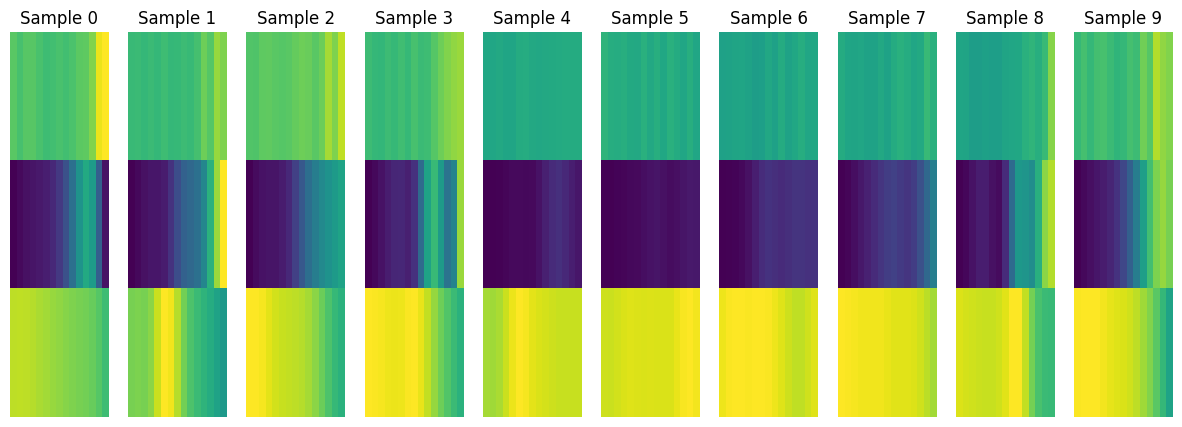

In [16]:
num_samples = 10  # Số lượng ma trận muốn hiển thị
fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))

for i in range(num_samples):
    ax = axes[i]
    ax.imshow(data[i], cmap='viridis', aspect='auto')
    ax.set_title(f"Sample {i}")
    ax.axis("off")

plt.show()

# 1. K mean with DTW distance

Vấn đề bao gồm:
- Chọn k cluster tối ưu
- Đánh giá mô hình
- Phân tích lý do cùng cụm

# 1.1. Chọn K clusters tối ưu cho mô hình K-means

Việc chọn K clusters tối ưu giúp mô hình giảm thiểu chi phí tính toán, tránh trùm lặp dữ liệu trong các cụm. Các phương pháp chọn K tối ưu bao gồm:

- `Elbow method`
- `Silhoutte method`

Cách thức hoạt động:

`Elbow method`: Phương pháp chọn K trong một khoảng cho trước. Đối với mỗi K, tính giá trị `WSS` (`Within-Cluster-Sum of Squared`) và chọn K tại điểm mà giá trị WSS theo K mà tại đó độ giảm trở nên ít đáng kể.

Lưu ý: Việc tính toán `WSS` có hơi phức tạp do:
- Giá trị Squared Error đối với mỗi điểm là giá trị khoảng cách từ điểm đó đến tâm cụm.
- `WSS` là tổng của toàn bộ các giá trị Squared Error.


`Silhouette method`: giá trị Silhouette nằm trong khoảng -1 đến 1 và giá trị càng cao thì càng tốt. Tuy nhiên, phương pháp này chỉ hỗ trợ khoảng cách Euclidean. Có thể không phù hợp với loại dữ liệu sử dụng DTW.

`Davies-Bouldin Index (DBI)`: phương pháp đánh giá chất lượng phân cụm bằng đo độ chồng lấn giữa các cụm. DBI càng nhỏ càng tốt, phản ảnh các cụm dữ liệu tách biệt và cô đọng.

Công thức `DBI`: 
$$
DBI = \frac{1}{n} \sum_{i = 1}^n max_{i \neq j}(\frac{s_i + s_j}{d_{ij}})
$$

Trong đó:
- n là số cụm
- si là độ chặt chẽ của cụm i: độ lệch chuẩn trung bình giữa các điểm trong cụm đó và tâm cụm.
- dij là khoảng cách giữa tâm cụm i và j

In [17]:
# possible_k = range(2, 15)
# wcss = []

# for k in tqdm(possible_k):
#     model = TimeSeriesKMeans(n_clusters=k, metric="dtw")
#     model.fit(data)
#     wcss.append(model.inertia_)

# plt.figure(figsize=(20, 6))
# plt.plot(possible_k, wcss, marker='x')
# plt.title("The Elbow Method")
# plt.xlabel("Number of clusters")
# plt.ylabel("WCSS")
# plt.show()

In [18]:
# from sklearn.metrics import davies_bouldin_score

# dbi_scores = []
# for k in tqdm(possible_k):
#     model = TimeSeriesKMeans(n_clusters=k, metric="dtw")
#     labels = model.fit_predict(data)

#     cluster_centers = model.cluster_centers_
#     dtw_distances = np.zeros(data.shape[0])

#     for i in range(100):
#         dtw_distances[i] = dtw(data[i].squeeze(), cluster_centers[labels[i]].squeeze())

#     # Tính Davies-Bouldin Index
#     dbi = davies_bouldin_score(dtw_distances.reshape(-1, 1), labels)
#     dbi_scores.append(dbi)

# plt.figure(figsize=(20, 5))
# plt.plot(possible_k, dbi_scores, marker='o', linestyle='-', color='b')
# plt.xlabel("Number of clusters (k)")
# plt.ylabel("Davies-Bouldin Index")
# plt.title("Choosing k using Davies-Bouldin Index")
# plt.grid(True)
# plt.show()

`Elbow method`:
- Đồ thị bắt đầu giảm không đáng kể từ k = 8.
- Giá trị tiềm năng cho k chạy từ 8 trở đi.

`DBI`:
- Từ 8 đến 11 có sự ổn định và giá trị DBI nhỏ. Các giá trị 12, 16, 18, 30 có sự dao động mạnh, chứng tỏ mô hình khó phân cụm tại các điểm này.
- Giá trị tiềm năng cho k chạy từ 8 đến 11.

Vì vậy, k tối ưu là 8

In [19]:
k_clusters = 8
model = TimeSeriesKMeans(n_clusters=8, metric="dtw")
labels = model.fit_predict(data)

In [20]:
import plotly.express as px
import plotly.graph_objects as go

X_3d = np.mean(data, axis=2)

colors = px.colors.qualitative.Set1
fig = go.Figure()

for i in range(k_clusters):
    cluster_points = X_3d[labels == i]
    
    fig.add_trace(go.Scatter3d(
        x=cluster_points[:, 0],
        y=cluster_points[:, 1],
        z=cluster_points[:, 2],
        mode='markers',
        marker=dict(size=6, color=colors[i % len(colors)], opacity=0.8),
        name=f'Cluster {i}'
    ))

# Cài đặt giao diện
fig.update_layout(
    title=f'Biểu diễn các cụm dữ liệu lấy theo giá trị trung bình của time-series',
    scene=dict(
        xaxis_title='Feature 1 (mean)',
        yaxis_title='Feature 2 (mean)',
        zaxis_title='Feature 3 (mean)',
    ),
    margin=dict(l=0, r=0, b=0, t=40),
    width=2000,  # Tăng chiều rộng
    height=900   # Tăng chiều cao
)
fig.show()

# 2. SOM

In [34]:
from minisom import MiniSom

In [35]:
reshaped_data = data.reshape((data.shape[0], -1))
reshaped_data.shape

(438, 45)

In [36]:
som_size = (5, 5)
som = MiniSom(som_size[0], som_size[1], reshaped_data.shape[1], sigma=0.3, learning_rate=0.5)
som.train_random(reshaped_data, 300000)

In [37]:
clusters = np.array([som.winner(x) for x in reshaped_data])
cluster_labels = np.array([c[0] * som_size[1] + c[1] for c in clusters])
print(np.unique(cluster_labels))

[ 1  5  6  7  8 10 11 12 13 15 16 17 18 20 21 22 23]


In [45]:
# Tính giá trị trung bình theo chiều thời gian (giữ nguyên 3D)
X_3d = np.mean(data, axis=2)  # Shape (438, 3)

# Vẽ biểu đồ 3D
color_set = (
    px.colors.qualitative.Set1 +
    px.colors.qualitative.Set2 +
    px.colors.qualitative.Set3
)[:20]
fig = go.Figure()

# Thêm từng cụm vào biểu đồ
unique_clusters = np.unique(cluster_labels)
for i, cluster in enumerate(unique_clusters):
    cluster_points = X_3d[cluster_labels == cluster]
    
    fig.add_trace(go.Scatter3d(
        x=cluster_points[:, 0],
        y=cluster_points[:, 1],
        z=cluster_points[:, 2],
        mode='markers',
        marker=dict(size=6, color=colors[i % len(colors)], opacity=0.8),
        name=f'Cluster {cluster}'
    ))

# Cài đặt giao diện hiển thị
fig.update_layout(
    title='Phân cụm SOM - Biểu diễn dữ liệu trong không gian 3D',
    scene=dict(
        xaxis_title='Feature 1 (mean)',
        yaxis_title='Feature 2 (mean)',
        zaxis_title='Feature 3 (mean)',
    ),
    margin=dict(l=0, r=0, b=0, t=40),
    width=1200,  # Tăng chiều rộng
    height=800   # Tăng chiều cao
)

fig.show()

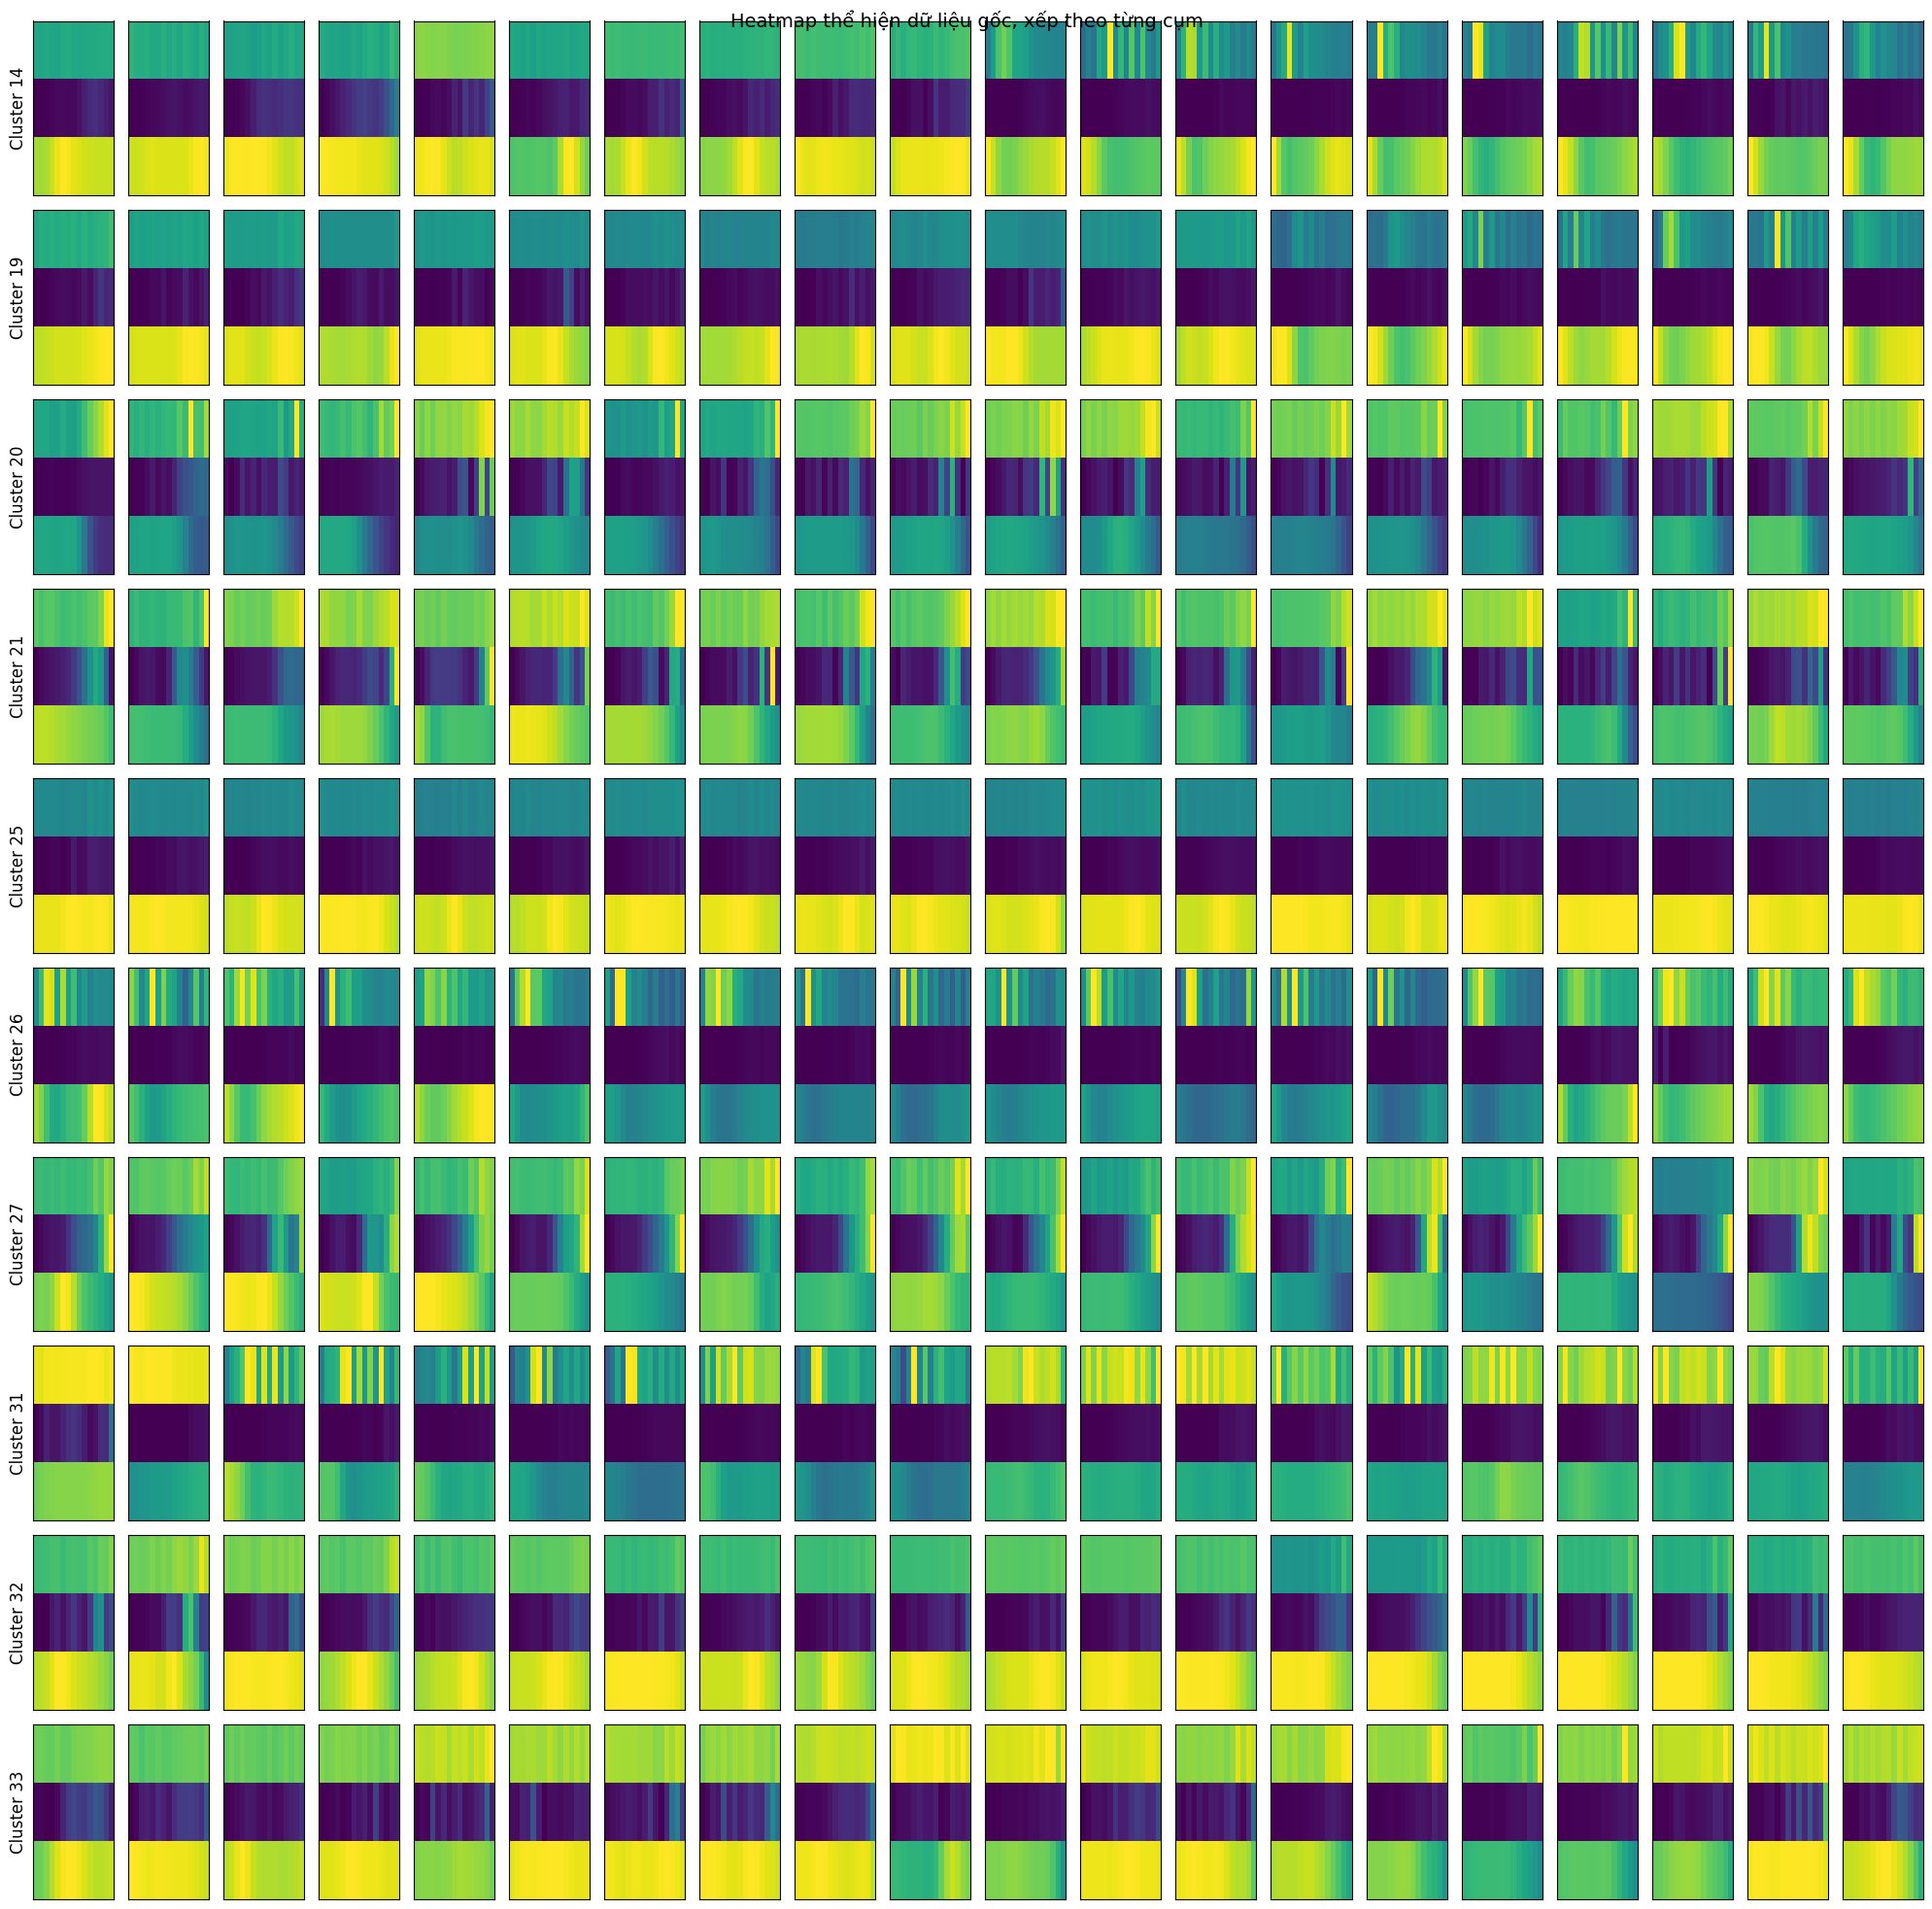

In [ ]:
sorted_indices = np.argsort(cluster_labels)
sorted_data = data[sorted_indices]
sorted_labels = cluster_labels[sorted_indices]

num_samples = 20  # Chọn số lượng ma trận muốn hiển thị
clusters = np.unique(cluster_labels)

fig, axes = plt.subplots(len(clusters), num_samples, figsize=(num_samples, len(clusters) * 2))

for row, cluster in enumerate(clusters):
    cluster_indices = np.where(cluster_labels == cluster)[0][:num_samples]  # Lấy các sample trong cụm
    
    for col, idx in enumerate(cluster_indices):
        ax = axes[row, col] if len(clusters) > 1 else axes[col]
        ax.imshow(data[idx], cmap="viridis", aspect="auto")
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ghi nhãn cụm
    axes[row, 0].set_ylabel(f"Cluster {cluster}", fontsize=12)

plt.tight_layout()
plt.show()

# HDBSCAN

In [47]:
import numpy as np
import hdbscan
import plotly.graph_objects as go
import plotly.express as px

In [50]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=5)
labels = clusterer.fit_predict(reshaped_data)

In [ ]:
colors = px.colors.qualitative.Set1 + px.colors.qualitative.Set2 + px.colors.qualitative.Set3
fig = go.Figure()

unique_clusters = np.unique(labels)
for i, cluster in enumerate(unique_clusters):
    cluster_points = X_3d[labels == cluster]
    
    fig.add_trace(go.Scatter3d(
        x=cluster_points[:, 0],
        y=cluster_points[:, 1],
        z=cluster_points[:, 2],
        mode='markers',
        marker=dict(size=6, color=colors[i % len(colors)], opacity=0.8),
        name=f'Cluster {cluster}'
    ))

fig.update_layout(
    title="Phân cụm HDBSCAN - Biểu diễn dữ liệu trong không gian 3D",
    scene=dict(
        xaxis_title='Feature 1 (mean)',
        yaxis_title='Feature 2 (mean)',
        zaxis_title='Feature 3 (mean)',
    ),
    margin=dict(l=0, r=0, b=0, t=40),
    width=1200,
    height=800
)

fig.show()

In [56]:
from sklearn.mixture import GaussianMixture

X_flattened = data.reshape(438, -1)  

gmm = GaussianMixture(n_components=8, covariance_type='full', random_state=42)
labels = gmm.fit_predict(X_flattened)

In [58]:
colors = px.colors.qualitative.Set1 + px.colors.qualitative.Set2 + px.colors.qualitative.Set3
fig = go.Figure()

unique_clusters = np.unique(labels)
for i, cluster in enumerate(unique_clusters):
    cluster_points = X_3d[labels == cluster]
    
    fig.add_trace(go.Scatter3d(
        x=cluster_points[:, 0],
        y=cluster_points[:, 1],
        z=cluster_points[:, 2],
        mode='markers',
        marker=dict(size=6, color=colors[i % len(colors)], opacity=0.8),
        name=f'Cluster {cluster}'
    ))

# 🔧 Cấu hình hiển thị
fig.update_layout(
    scene=dict(
        xaxis_title='Feature 1 (mean)',
        yaxis_title='Feature 2 (mean)',
        zaxis_title='Feature 3 (mean)',
    ),
    margin=dict(l=0, r=0, b=0, t=40),
    width=1200,
    height=800
)

fig.show()